In [4]:
import sys
sys.path.append('../../')

In [5]:
from codes.docs.analysis import data_preprocessing, MLtraining
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import tqdm as tqdm

%matplotlib inline

from sklearn.linear_model import LinearRegression

# Diffusion dataset

In [6]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')
def calc_zero_proportion(column):
    return(column==0).sum()/len(column)

zero_proportions_features=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].agg(calc_zero_proportion)

print(f'removed {(zero_proportions_features>0).sum()} features, in which at least 1 of subjects registered zeros values ')
european_diffusion_dataset_term_reduced=european_diffusion_dataset_term.drop(columns=zero_proportions_features.index[zero_proportions_features>0])
#european_diffusion_dataset_term_reduced is the reduced version with non-zero features

removed 1492 features, in which at least 1 of subjects registered zeros values 


In [7]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term_reduced[PRS_thresholds]),
np.array(european_diffusion_dataset_term_reduced['Anc_PC1']),np.array(european_diffusion_dataset_term_reduced['Anc_PC2']),np.array(european_diffusion_dataset_term_reduced['Anc_PC3']))

In [8]:
def get_model_bias(y_true, y_pred):
    """
    Correct for bias in the regression model as shown in Yassine et al., 2020, 
    by fitting the predicted values to the true values in another linear model.
    The updated unbiased predicted values equals to the original predicted values * coeff + intercept
    Args:
        y_true
        y_pred
    Returns:
        model Coeff
        Intercept
    """
    model_error=y_true - y_pred
    lin_reg=LinearRegression()
    lin_reg.fit(y_true.reshape(-1,1),model_error)
    coeff=lin_reg.coef_
    intercept=lin_reg.intercept_
    return coeff,intercept

In [ ]:
european_diffusion

In [64]:
X=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
y=np.asarray(european_diffusion_dataset_term['PMA_diff'])

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr

In [11]:
scoring={'r2':'r2','MAE':'neg_mean_absolute_error','MSE':'neg_mean_squared_error'}
def print_scores(y_pred,y_true):
    return {'r2': r2_score(y_true,y_pred),
    'MAE': mean_absolute_error(y_true,y_pred),
    'MSE': mean_squared_error(y_true,y_pred),
    'Correlation':pearsonr(y_true,y_pred)[0],
    'p_value':pearsonr(y_true,y_pred)[1]}

In [65]:
data_splitting=MLtraining.splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    #regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    inner_cv=KFold(n_splits=3)
    regr=RidgeCV(cv=inner_cv)
    pipeline=Pipeline([('scaler',MinMaxScaler()),('regr',regr)])
    pipeline.fit(X_trainval,y_trainval)

    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #use the trained model to predict the brain age (PMA at scan) for all subject
    y_total_pred=pipeline.predict(X)
    y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

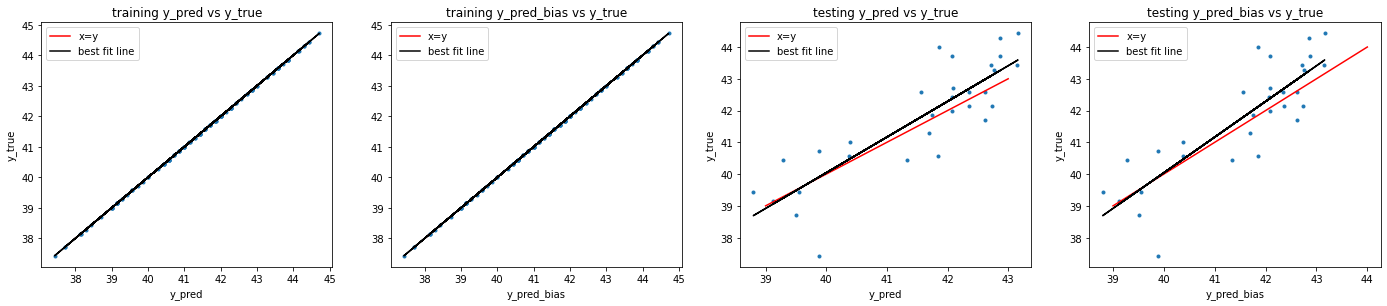

In [66]:
y_train_pred=pipeline.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipeline.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,44],[39,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



brain age difference is the difference between the predicted age and true age.
Negative value means delay in the brain maturation. 
At each iteration of

In [67]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.691594,0.721233,0.803681,0.833971,5.646317e-09
1,0.598934,0.668393,0.873878,0.799928,1.131881e-07
2,0.741967,0.721514,0.719801,0.883821,9.693337e-11
3,0.801687,0.747033,0.907694,0.914825,1.529547e-12
4,0.700964,0.746785,0.914636,0.852345,2.270740e-09
5,0.707029,0.720992,0.843938,0.856978,2.424072e-08


In [68]:
brain_age_difference=pd.DataFrame(y_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA_pred']=y
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA_pred']

In [69]:
brain_age_difference

,0,1,2,3,4,mean_PMA_pred,true_PMA_pred,residual
0,42.657075,42.001284,42.107466,42.011865,42.001017,42.155742,42.000000,0.155742
1,40.901378,41.998799,41.907172,41.986694,41.998453,41.758499,42.000000,-0.241501
2,43.082401,42.858074,42.914322,42.866819,42.857389,42.915801,42.857143,0.058658
3,42.856043,42.857842,42.887867,42.861932,42.856863,42.864110,42.857143,0.006967
4,43.708189,43.286663,43.370722,43.297558,43.286564,43.389940,43.285714,0.104225
...,...,...,...,...,...,...,...,...
146,42.187016,42.143262,42.166538,42.145710,42.359435,42.200392,42.142857,0.057535
147,43.710462,43.714671,43.741093,43.716086,42.868347,43.550132,43.714286,-0.164154
148,42.019348,42.000342,42.044276,42.000089,42.077441,42.028299,42.000000,0.028299
149,42.535806,42.570566,42.534298,42.564083,41.555813,42.352113,42.571429,-0.219316


In [70]:
brain_age_difference_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_age_difference['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_age_difference['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})

In [71]:
brain_age_difference_corr

,PRS_threshold,Correlation,p-value
0,PRS_1e08,-0.039918,0.626511
1,PRS_1e07,-0.044027,0.591422
2,PRS_1e06,-0.044498,0.587456
3,PRS_1e05,-0.049614,0.545200
4,PRS_0.0001,-0.054618,0.505361
5,PRS_0.001,-0.025335,0.757486
6,PRS_0.01,-0.101669,0.214174
7,PRS_0.05,-0.105628,0.196770
8,PRS_0.1,-0.103364,0.206592
9,PRS_0.5,-0.138069,0.090908


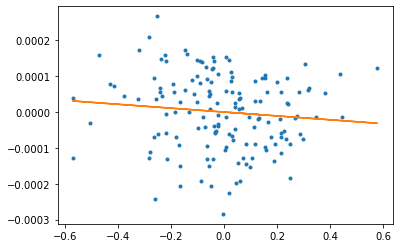

In [72]:
plt.plot(brain_age_difference['residual'],adjusted_prs_score[:,7],'.')
lin_reg=LinearRegression()
lin_reg.fit(np.asarray(brain_age_difference['residual']).reshape(-1,1),adjusted_prs_score[:,7])
plt.plot(brain_age_difference['residual'],lin_reg.predict(np.asarray(brain_age_difference['residual']).reshape(-1,1)))

In [26]:
# high_risk=[data_preprocessing.high_low_risk_divide(adjusted_prs_score[:,i],percentage=0.3)[1] for i in range(7,9)]
# low_risk=[data_preprocessing.high_low_risk_divide(adjusted_prs_score[:,i],percentage=0.3)[0] for i in range(7,9)]
high_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score[:,7],percentage=0.3)[1]
low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score[:,7],percentage=0.3)[0]

In [25]:
for i in range(1,2):
    if i==1:
        uniq_high_risk=set(high_risk[0])&set(high_risk[1])
    else:
        uniq_high_risk=set(uniq_high_risk)&set(high_risk[i])

for i in range(1,2):
    if i==1:
        uniq_low_risk=set(low_risk[0])&set(low_risk[1])
    else:
        uniq_low_risk=set(uniq_low_risk)&set(low_risk[i])

TypeError: 'numpy.int64' object is not iterable

In [24]:
high_risk=np.asarray(list(uniq_high_risk))
low_risk=np.asarray(list(uniq_low_risk))

NameError: name 'uniq_high_risk' is not defined

In [84]:
X_high_risk=np.array(european_diffusion_dataset_term_reduced.iloc[high_risk,203:2716])
X_low_risk=np.array(european_diffusion_dataset_term_reduced.iloc[low_risk,203:2716])

# y_total=np.array(european_diffusion_dataset_term_removed_zeros.loc[:,'PMA.at.birth'])
y_low_risk=np.array(european_diffusion_dataset_term_reduced.iloc[low_risk]['PMA_diff'])
y_high_risk=np.array(european_diffusion_dataset_term_reduced.iloc[high_risk]['PMA_diff'])

#Train on low risk, predict brain maturation on high risk

data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk,y_low_risk,k=3)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(3)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    #regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    # inner_cv=KFold(n_splits=3)
    # regr=RidgeCV(cv=inner_cv)
    regr=Ridge()
    pipeline=Pipeline([('scaler',MinMaxScaler()),('regr',regr)])
    pipeline.fit(X_trainval,y_trainval)

    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #use the trained model to predict the brain age (PMA at scan) for all subject
    y_high_risk_pred=pipeline.predict(X_high_risk)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_high_risk_pred

100%|██████████| 3/3 [00:00<00:00, 85.94it/s]


In [91]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.518450,0.846271,1.091882,0.760885,0.000016
1,0.582858,0.800062,1.129980,0.766785,0.000012
2,0.641757,0.781927,1.133840,0.809460,0.000003
3,0.581022,0.809420,1.118567,0.779043,0.000010


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

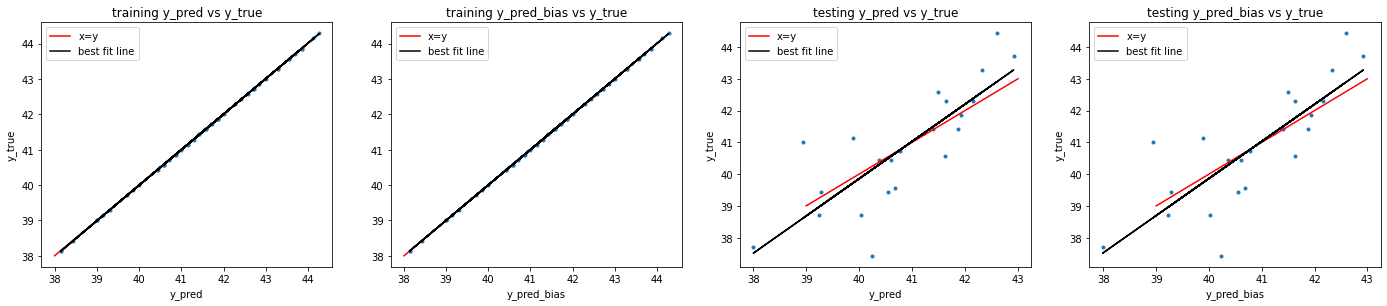

In [85]:
y_train_pred=pipeline.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipeline.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [31]:
brain_age_difference=pd.DataFrame(y_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA_pred']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA_pred']

brain_age_difference

# brain_age_difference_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds[7:9],'Correlation':[(pearsonr(brain_age_difference['residual'],adjusted_prs_score[low_risk,i]))[0] for i in range(7,9)],'p-value':[(pearsonr(brain_age_difference['residual'],adjusted_prs_score[low_risk,i]))[1] for i in range(7,9)]})

# brain_age_difference_corr

,0,1,2,mean_PMA_pred,true_PMA_pred,residual
0,42.262959,42.451938,42.326764,42.347220,42.000000,0.347220
1,40.818608,40.681022,40.813151,40.770927,42.000000,-1.229073
2,42.055986,42.516551,42.032998,42.201845,42.000000,0.201845
3,41.241509,41.599840,41.630268,41.490539,43.000000,-1.509461
4,38.907041,39.296963,39.622602,39.275535,39.285714,-0.010179
5,40.625678,39.856323,40.132212,40.204738,38.142857,2.061881
6,40.111367,39.793027,40.185396,40.029930,39.142857,0.887073
7,40.133706,40.148496,40.388469,40.223557,40.000000,0.223557
8,39.409723,39.530437,39.656308,39.532156,39.571429,-0.039273
9,42.654611,42.975127,42.280498,42.636746,43.571429,-0.934683


In [32]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk,7]))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk,7]))[1]},index=[PRS_thresholds[7]])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.403005,0.001882


Text(0.5, 0, 'adjusted prs score')

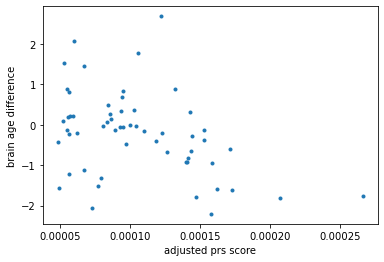

In [33]:
plt.plot(adjusted_prs_score[high_risk,7],brain_age_difference['residual'],'.')
plt.ylabel('brain age difference')
plt.xlabel('adjusted prs score')

In [246]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [247]:
prefrontal_lobes=['SFGdor','ORBsup','MFG','ORBmid','IFGoperc','IFGtriang','ORBinf','SFGmed','ORBsumed']
cingulum=['ACG','DCG','PCG']
subcortical=['HIP','PHG','AMYG','CAU','PUT','PAL','THA','INS']
temporal=['STG','TPOsup','MTG','TPOmid','ITG']
occipital=['REC','CUN','CAL','LING','SOG','MOG','IOG','FFG']
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [248]:
temp_connectivity_list_ROIs=[region for region in data_preprocessing.lower_triangle(ROIs_combinations) for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[0]]
connectivity_list_ROIs=[region for region in temp_connectivity_list_ROIs for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[1]]

In [249]:
X=np.asarray(european_diffusion_dataset_term_removed_zeros[[i for i in connectivity_list_ROIs if i in european_diffusion_dataset_term_removed_zeros.columns]])
y=np.array(european_diffusion_dataset_term_removed_zeros['PMA.at.birth'])

In [252]:
data_splitting=MLtraining.splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipeline=Pipeline([('scaler',MinMaxScaler()),('RFregressor',regr)])
    pipeline.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #calculate brain_maturation_index
    y_total_pred=pipeline.predict(X)
    y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


In [253]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.743919,0.856973,1.046373,0.898203,7.219065e-12
1,0.655156,0.737832,1.006733,0.819095,3.137436e-08
2,0.700002,0.709359,0.729988,0.839202,6.878096e-09
3,0.543457,0.912063,1.179558,0.741647,2.738711e-06
4,0.660318,0.799994,0.884782,0.829943,1.417570e-08
5,0.660570,0.803244,0.969487,0.825618,5.582293e-07


In [278]:
brain_index=pd.DataFrame(y_pred_dict)
brain_index['mean_PMA_pred']=brain_index.mean(axis=1)
brain_index['true_PMA_pred']=y
brain_index['residual']=brain_index['mean_PMA_pred']-brain_index['true_PMA_pred']

In [279]:
brain_index_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})
brain_index_corr

,PRS_threshold,Correlation,p-value
0,X1e.08,-0.067966,0.406994
1,X1e.07,-0.071368,0.383859
2,X1e.06,-0.071514,0.382885
3,X1e.05,-0.063584,0.437971
4,X0.0001,-0.094008,0.250912
5,X0.001,-0.079683,0.330764
6,X0.01,-0.145131,0.075402
7,X0.05,-0.161967,0.046936
8,X0.1,-0.153344,0.060136
9,X0.5,-0.152774,0.061106


In [281]:
X=np.asarray(european_diffusion_dataset_term_removed_zeros[[i for i in connectivity_list_ROIs if i in european_diffusion_dataset_term_removed_zeros.columns]])
y=np.array(european_diffusion_dataset_term_removed_zeros['PMA.at.birth'])

In [286]:
data_splitting=splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipeline=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=1)),('RFregressor',regr)])
    pipeline.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #calculate brain_maturation_index
    y_total_pred=pipeline.predict(X)
    y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


In [287]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.557144,1.106079,1.809550,0.753987,9.701348e-07
1,0.161479,1.291396,2.447969,0.601070,4.436980e-04
2,-0.097452,1.416533,2.670442,0.512832,3.757923e-03
3,0.258628,1.059618,1.915464,0.657584,7.862737e-05
4,0.182292,1.146366,2.129916,0.617347,2.788538e-04
5,0.212418,1.203998,2.194668,0.628564,9.120145e-04


In [288]:
brain_index=pd.DataFrame(y_pred_dict)
brain_index['mean_PMA_pred']=brain_index.mean(axis=1)
brain_index['true_PMA_pred']=y
brain_index['residual']=brain_index['mean_PMA_pred']-brain_index['true_PMA_pred']

In [289]:
brain_index_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_index['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})
brain_index_corr

,PRS_threshold,Correlation,p-value
0,X1e.08,-0.094409,0.248890
1,X1e.07,-0.109261,0.181722
2,X1e.06,-0.087957,0.282850
3,X1e.05,-0.072906,0.373669
4,X0.0001,-0.083216,0.309705
5,X0.001,-0.053845,0.511417
6,X0.01,-0.085599,0.296008
7,X0.05,-0.143565,0.078643
8,X0.1,-0.133181,0.103053
9,X0.5,-0.173206,0.033436


# Looking at volumetric data


In [39]:
european_ID_dataset_without_outlier_term=pd.read_csv('./preprocessed_data/volumetric/term/european_ID_dataset_without_outlier_term.csv')

In [12]:
import statsmodels.api as sm
import pandas as pd

In [41]:
model_list={}
for threshold in tqdm.tqdm(['1e-08','1e-07','1e-06','1e-05','0.0001','0.001','0.01','0.05', '0.1', '0.5', '1']):
    X=european_ID_dataset_without_outlier_term[['GA at birth','PMA at birth','Anc_PC1','Anc_PC2','Anc_PC3',threshold]].copy()
    X=sm.add_constant(X)
    model_list[threshold]={}
    for region in european_ID_dataset_without_outlier_term.columns[4027:4120]:
        y=european_ID_dataset_without_outlier_term[region]
        model=sm.OLS(y,X).fit()
        model_list[threshold][region]=list(model.pvalues)
        model_list[threshold][region].append(threshold)

100%|██████████| 11/11 [00:01<00:00,  9.87it/s]


In [43]:
volumetric_term_p_val=list()
for (threshold,threshold_dict) in model_list.items():
    volumetric_term_p_val.append(pd.DataFrame(threshold_dict).T)

volumetric_term_p_val=pd.concat(volumetric_term_p_val)
volumetric_term_p_val.reset_index(level=volumetric_term_p_val.index.names, inplace=True)
volumetric_term_p_val.columns=['Connection','const_pval','GA.at.birth_pval','PMA.at.birth_pval','Anc_PC1_pval','Anc_PC2_pval','Anc_PC3_pval','prs_pval','PRS_threshold']

In [45]:
volumetric_term_p_val.sort_values(by=['prs_pval'],ascending=True)

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
746,'3 Frontal_Sup_L 2101',0.000386943,5.51545e-05,6.96733e-25,0.625129,0.765692,0.307968,0.00148266,0.1
839,'3 Frontal_Sup_L 2101',0.000319496,8.35528e-05,1.13742e-24,0.606065,0.848823,0.348609,0.0022661,0.5
932,'3 Frontal_Sup_L 2101',0.000320462,9.47634e-05,1.35165e-24,0.603089,0.835401,0.346757,0.00236291,1
945,'16 Frontal_Inf_Orb_R 2322',5.08156e-08,0.0223633,8.47854e-28,0.893393,0.185137,0.411528,0.00300046,1
852,'16 Frontal_Inf_Orb_R 2322',4.9302e-08,0.0206719,7.2773e-28,0.893706,0.19058,0.414572,0.00301102,0.5
...,...,...,...,...,...,...,...,...,...
349,'71 Caudate_L 7001',0.0915188,2.96769e-06,5.08888e-26,0.120798,0.869339,0.276861,0.986271,1e-05
506,'42 Amygdala_R 4202',0.321176,0.00384142,2.88346e-19,0.550635,0.748719,0.706608,0.987458,0.001
733,'83 Temporal_Pole_Sup_L 8121',0.522755,3.57291e-06,8.73572e-18,0.296564,0.069851,0.312327,0.996984,0.05
165,'73 Putamen_L 7011',0.634561,0.00200059,4.75818e-18,0.461287,0.786512,0.51795,0.997204,1e-07


In [53]:
# volumetric_corr_matrix=np.corrcoef(european_ID_dataset_without_outlier_term.iloc[:,4027:4120],rowvar=False)
# np.savetxt('volumetric_corr_matrix.txt',volumetric_corr_matrix)

In [56]:
print(f'Effective number of independent tests for 93 regions is 27 and for 11 thresholds is 3 so, the corrected pvalue is {0.05/(27*3)}')

Effective number of independent tests for 93 regions is 27 and for 11 thresholds is 3 so, the corrected pvalue is 0.0006172839506172839


In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Text(0.5, 0, 'PCs')

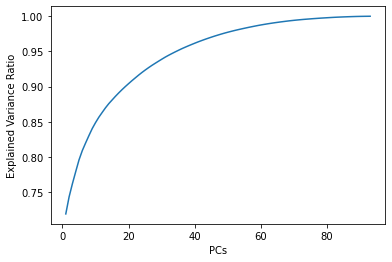

In [57]:
X=StandardScaler().fit_transform(np.asarray(european_ID_dataset_without_outlier_term.iloc[:,4027:4120]))
pca=PCA()
X=pca.fit_transform(X)

plt.plot(np.arange(1,X.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')

In [59]:
model_list_pca={}
for threshold in tqdm.tqdm(['1e-08','1e-07','1e-06','1e-05','0.0001','0.001','0.01','0.05', '0.1', '0.5', '1']):
    covariates=european_ID_dataset_without_outlier_term[['GA at birth','PMA at birth','Anc_PC1','Anc_PC2','Anc_PC3',threshold]].copy()
    covariates=sm.add_constant(covariates)
    model_list_pca[threshold]={}
    for PC in range(10):
        y=X[:,PC]
        model=sm.OLS(y,covariates).fit()
        model_list_pca[threshold]['PC'+str(PC)]=list(model.pvalues)
        model_list_pca[threshold]['PC'+str(PC)].append(threshold)

100%|██████████| 11/11 [00:00<00:00, 51.81it/s]


In [60]:
volumetric_term_p_val_pca=list()
for (threshold,threshold_dict) in model_list_pca.items():
    volumetric_term_p_val_pca.append(pd.DataFrame(threshold_dict).T)

volumetric_term_p_val_pca=pd.concat(volumetric_term_p_val_pca)
volumetric_term_p_val_pca.reset_index(level=volumetric_term_p_val_pca.index.names, inplace=True)
volumetric_term_p_val_pca.columns=['Connection','const_pval','GA.at.birth_pval','PMA.at.birth_pval','Anc_PC1_pval','Anc_PC2_pval','Anc_PC3_pval','prs_pval','PRS_threshold']

In [62]:
volumetric_term_p_val_pca.sort_values(by=['prs_pval'])

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
59,PC9,0.160072,0.55369,0.255363,0.433341,0.485268,0.497782,0.00142611,0.001
49,PC9,0.0747033,0.502847,0.277672,0.541193,0.537465,0.608308,0.0113786,0.0001
43,PC3,0.00667248,0.929798,0.00172096,0.509849,0.778899,0.664732,0.0156151,0.0001
99,PC9,0.977538,0.49925,0.248681,0.313984,0.600694,0.495358,0.0156653,0.5
18,PC8,0.0292181,0.162974,0.482811,0.47547,0.243719,0.963516,0.0163224,1e-07
...,...,...,...,...,...,...,...,...,...
61,PC1,0.0957125,0.500864,0.261857,0.853661,0.68572,0.063345,0.915545,0.01
81,PC1,0.140191,0.495644,0.263131,0.857547,0.687205,0.0659592,0.928409,0.1
77,PC7,0.1795,0.33598,0.684839,0.990218,0.950199,0.270336,0.933448,0.05
65,PC5,0.434393,0.0222906,8.37248e-05,0.566521,0.271016,0.00423685,0.947812,0.01


In [63]:
volumetric_term_p_val_pca.loc[volumetric_term_p_val_pca['Connection']=='PC0',:].sort_values(by=['prs_pval'],ascending=True)

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
90,PC0,6.18828e-13,1.55826e-05,3.17994e-35,0.30988,0.810695,0.261192,0.0325413,0.5
100,PC0,8.2689e-13,1.71617e-05,3.6591e-35,0.306244,0.800741,0.261123,0.0346774,1
80,PC0,1.45793e-13,1.14804e-05,3.15541e-35,0.285776,0.749106,0.254205,0.0488543,0.1
60,PC0,1.05964e-14,1.8568e-05,4.96301e-35,0.224866,0.775035,0.310096,0.0506475,0.01
40,PC0,1.30424e-14,1.49215e-05,3.45509e-35,0.137362,0.741553,0.341347,0.0759918,0.0001
70,PC0,2.94376e-13,1.16744e-05,4.22629e-35,0.251688,0.710025,0.289178,0.117351,0.05
50,PC0,2.45055e-14,1.47158e-05,6.96555e-35,0.131418,0.708225,0.3348,0.236425,0.001
30,PC0,2.74516e-14,1.41554e-05,6.48165e-35,0.115759,0.745383,0.384279,0.269023,1e-05
20,PC0,3.06271e-14,1.31863e-05,6.92681e-35,0.115127,0.718843,0.395435,0.33979,1e-06
10,PC0,3.14238e-14,1.36424e-05,7.40931e-35,0.115762,0.723593,0.386959,0.356012,1e-07


In [102]:
X=np.array(european_ID_dataset_without_outlier_term.iloc[:,4027:4120])
#X=data_preprocessing.adjusting_for_covariates_with_lin_reg(X,np.array(european_ID_dataset_without_outlier_term['GA at birth']))
y=np.array(european_ID_dataset_without_outlier_term['PMA at birth'])

In [103]:
#preprocess the PRS score
PRS_thresholds=['1e-08','1e-07','1e-06','1e-05','0.0001','0.001','0.01','0.05', '0.1', '0.5', '1']
adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_ID_dataset_without_outlier_term[PRS_thresholds]),
np.array(european_ID_dataset_without_outlier_term['Anc_PC1']),np.array(european_ID_dataset_without_outlier_term['Anc_PC2']),np.array(european_ID_dataset_without_outlier_term['Anc_PC3']))

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr

In [105]:
scoring={'r2':'r2','MAE':'neg_mean_absolute_error','MSE':'neg_mean_squared_error'}
def print_scores(y_pred,y_true):
    return {'r2': r2_score(y_true,y_pred),
    'MAE': mean_absolute_error(y_true,y_pred),
    'MSE': mean_squared_error(y_true,y_pred),
    'Correlation':pearsonr(y_true,y_pred)[0],
    'p_value':pearsonr(y_true,y_pred)[1]}

In [106]:
data_splitting=MLtraining.splitting_dataset_into_k_fold(X,y,k=5)
result={}
y_pred_dict={}
for i in tqdm.tqdm(range(5)):
    X_trainval,y_trainval,X_test,y_test=next(data_splitting)
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipeline=Pipeline([('scaler',MinMaxScaler()),('RFregressor',regr)])
    pipeline.fit(X_trainval,y_trainval)

    bias_coeff,bias_intercept=get_model_bias(y_trainval,pipeline.predict(X_trainval))
    y_pred=pipeline.predict(X_test)
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=print_scores(y_pred,y_test)

    #use the trained model to predict the brain age (PMA at scan) for all subject
    y_total_pred=pipeline.predict(X)
    y_total_pred=y_total_pred+y_total_pred*bias_coeff+bias_intercept
    y_pred_dict[i]=y_total_pred

100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

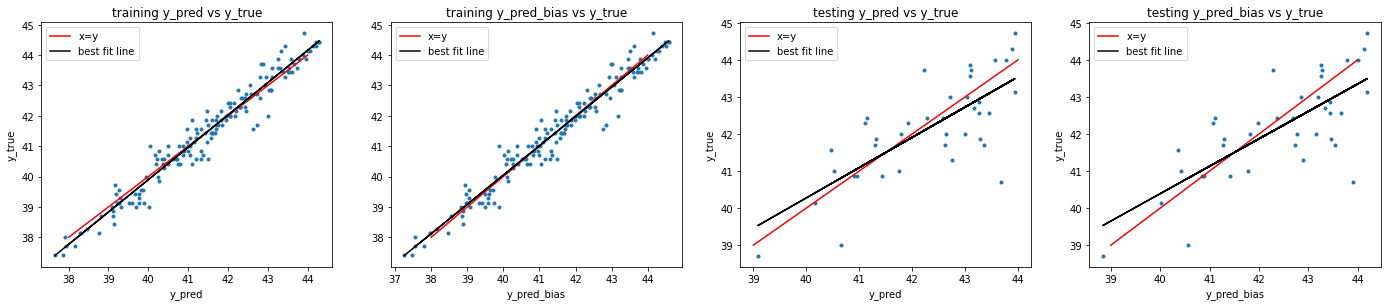

In [107]:
y_train_pred=pipeline.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipeline.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,44],[39,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,44],[39,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [108]:
PMA_RF_result=pd.DataFrame(result).T
PMA_RF_result.append(pd.DataFrame(PMA_RF_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.767248,0.765597,0.859034,0.878546,9.305014e-14
1,0.769985,0.686346,0.717635,0.886036,2.970601e-14
2,0.462689,0.894391,1.241270,0.686033,1.029450e-06
3,0.612475,0.780809,1.037591,0.805653,6.156851e-10
4,0.454677,0.737589,0.965395,0.744117,5.657171e-08
5,0.613415,0.772946,0.964185,0.800077,2.173275e-07


In [109]:
brain_age_difference=pd.DataFrame(y_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA_pred']=y
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA_pred']

In [110]:
brain_age_difference

,0,1,2,3,4,mean_PMA_pred,true_PMA_pred,residual
0,37.849194,37.452698,37.615251,37.731265,37.247878,37.579257,37.428571,0.150686
1,43.307311,43.506853,43.439183,43.258784,43.716889,43.445804,43.428571,0.017233
2,44.054326,44.619710,44.619853,44.607220,44.578723,44.495967,44.428571,0.067395
3,39.937565,38.858412,39.261835,39.127860,39.313127,39.299760,39.142857,0.156903
4,40.035713,41.318412,41.506696,41.155865,41.052561,41.013849,41.857143,-0.843293
...,...,...,...,...,...,...,...,...
193,42.712970,42.692178,42.412053,42.969833,43.443625,42.846132,42.571429,0.274703
194,44.157926,44.609061,44.392190,44.660730,44.195102,44.403002,44.714286,-0.311284
195,41.840544,42.239581,41.591408,41.509027,43.911328,42.218378,40.714286,1.504092
196,43.514512,43.757113,43.433889,43.066150,43.285972,43.411527,43.714286,-0.302759


In [111]:
brain_age_difference_corr=pd.DataFrame({'PRS_threshold':PRS_thresholds,'Correlation':[(pearsonr(brain_age_difference['residual'],adjusted_prs_score[:,i]))[0] for i in range(11)],'p-value':[(pearsonr(brain_age_difference['residual'],adjusted_prs_score[:,i]))[1] for i in range(11)]})

In [112]:
brain_age_difference_corr

,PRS_threshold,Correlation,p-value
0,1e-08,-0.074013,0.300070
1,1e-07,-0.088791,0.213519
2,1e-06,-0.085178,0.232812
3,1e-05,-0.092536,0.194759
4,0.0001,-0.123366,0.083354
5,0.001,-0.109611,0.124236
6,0.01,-0.156204,0.027980
7,0.05,-0.142495,0.045218
8,0.1,-0.158546,0.025685
9,0.5,-0.179553,0.011369


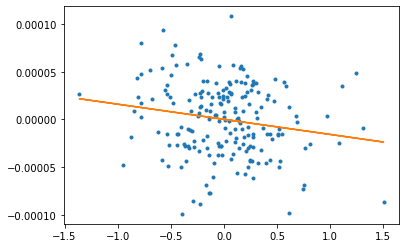

In [113]:
plt.plot(brain_age_difference['residual'],adjusted_prs_score[:,9],'.')
lin_reg=LinearRegression()
lin_reg.fit(np.asarray(brain_age_difference['residual']).reshape(-1,1),adjusted_prs_score[:,9])
plt.plot(brain_age_difference['residual'],lin_reg.predict(np.asarray(brain_age_difference['residual']).reshape(-1,1)))